In [1]:
from utils import prepare_image_forgery_dataset

data_directory = '../data'

IMG_SIZE=(128, 128)

X_train, X_test, y_train, y_test = prepare_image_forgery_dataset(total_number=6000, test_size=0.2, random_state=42, 
                                                                 data_directory=data_directory, img_size=IMG_SIZE)

2024-07-09 16:03:00.698832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 16:03:00.698974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 16:03:00.701291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 16:03:00.715112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 16:03:01.610339: W tensorflow/compiler/tf2

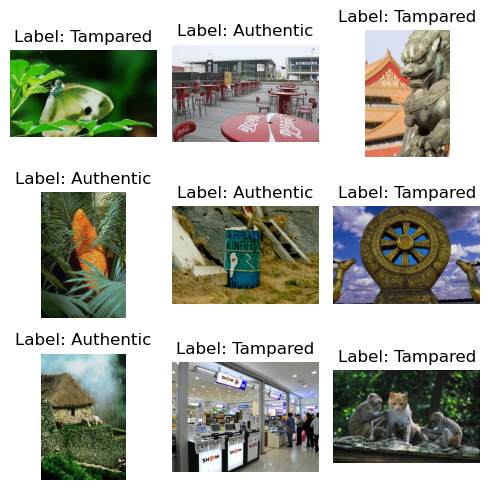

In [2]:
from utils import display_images

classnames = ['Authentic', 'Tampared']

display_images(X_train, y_train, classnames=classnames)

In [3]:
from models.cnn import CNNImageForgeryDetector

model = CNNImageForgeryDetector(compression_quality=98, learning_rate=0.0001, img_size=IMG_SIZE, epochs=10)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
history = model.fit(X_train, y_train, X_val, y_val)

Epoch 1/10
135/135 [==============================] - 125s 922ms/step - loss: 0.7205 - accuracy: 0.5986 - val_loss: 0.6521 - val_accuracy: 0.6208
Epoch 2/10
135/135 [==============================] - 120s 888ms/step - loss: 0.6001 - accuracy: 0.7000 - val_loss: 0.6089 - val_accuracy: 0.6646
Epoch 3/10
135/135 [==============================] - 121s 895ms/step - loss: 0.4954 - accuracy: 0.7977 - val_loss: 0.5856 - val_accuracy: 0.7063
Epoch 4/10
135/135 [==============================] - 121s 900ms/step - loss: 0.3780 - accuracy: 0.8743 - val_loss: 0.6022 - val_accuracy: 0.7104
Epoch 5/10
135/135 [==============================] - 121s 897ms/step - loss: 0.2778 - accuracy: 0.9097 - val_loss: 0.6474 - val_accuracy: 0.7083
Epoch 6/10
135/135 [==============================] - 121s 898ms/step - loss: 0.1937 - accuracy: 0.9465 - val_loss: 0.8992 - val_accuracy: 0.6917
Epoch 7/10
135/135 [==============================] - 121s 897ms/step - loss: 0.1418 - accuracy: 0.9641 - val_loss: 0.7692 -

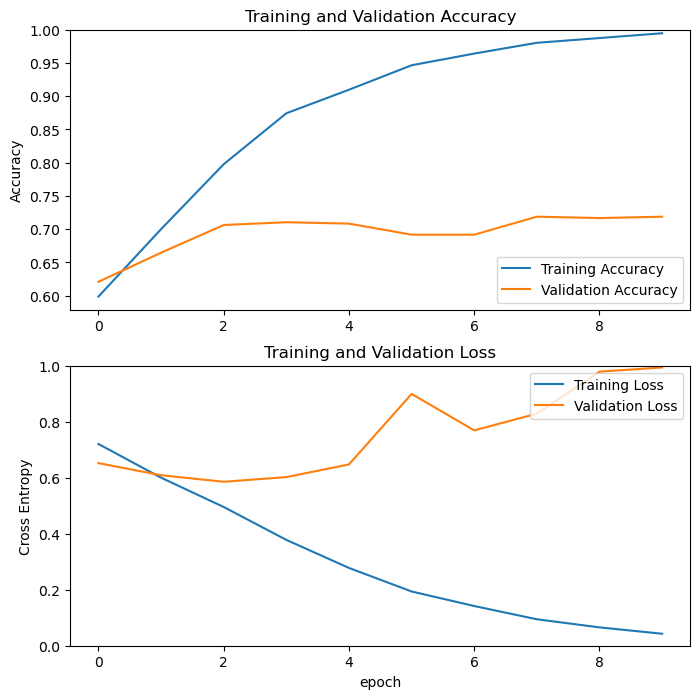

In [6]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [7]:
y_pred = model.predict(X_test)

38/38 [==============================] - 4s 104ms/step


In [8]:
from utils import print_model_performance_metrics

print_model_performance_metrics(y_test, y_pred)

+----------------------+--------------------+
| Metric               |              Value |
+----------------------+--------------------+
| False Positives (FP) |                207 |
| False Negatives (FN) |                161 |
| True Positives (TP)  |                319 |
| True Negatives (TN)  |                513 |
| Precision            | 0.6064638783269962 |
| Recall               | 0.6645833333333333 |
| F1-score             | 0.6341948310139165 |
| Overall Accuracy     | 0.6933333333333334 |
+----------------------+--------------------+
